# Машинное обучение, ФКН ВШЭ

# Практическое задание 10. Обучение без учителя.

## Общая информация
Дата выдачи: 13.03.2021

Мягкий дедлайн: 28.03.2021 01:59 MSK

Жёсткий дедлайн: 01.04.2021 01:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-10-Username.ipynb

Username — ваша фамилия на латинице

## О задании

В этом задании мы посмотрим на несколько алгоритмов кластеризации и применим их к географическим и текстовым данным. Также мы подробно остановимся на тематическом моделировании текстов, задаче обучения представлений и в каком-то смысле поработаем с semi-supervised learning. 



In [138]:
import pandas as pd
import numpy as np

np.random.seed(0xFFFFFFF)

**Задание 0 (1e-100 балла)**. Опишите свои ощущения от домашки по ЕМ-алгоритму (можно картинкой или мемом).

In [139]:
# YOUR CODE HERE (ノಠ益ಠ)ノ彡┻━┻
# это и есть мои ощущения

## Часть 1. Кластеризация автобусных остановок

В этом задании мы сравним разные алгоритмы кластеризации для данных об автобусных остановках Москвы.

**Задание 1.1 (1 балл).** Реализуйте алгоритм спектральной кластеризации, который упоминался на лекции. Для этого разберитесь с кодом шаблона, данного ниже, и допишите недостающую функцию. Напомним, что для графа с матрицей смежности $W = \{w_{ij}\}_{i, j = 1 \dots \ell}$ лапласиан определяется как:

$$
L = D - W,
$$

где $D = \text{diag}(d_1, ..., d_{\ell}), d_i = \sum_{j=1}^{\ell} w_{ij}$.

In [140]:
from sklearn.base import ClusterMixin
from sklearn.cluster import KMeans


class GraphClustering(ClusterMixin):
    def __init__(self, n_clusters=8, n_components=None, **kwargs):
        '''
        Spectral clustering algorithm
        param n_clusters: number of clusters to form
        param n_components: number of eigenvectors to use
        '''

        if n_components is None:
            n_components = n_clusters

        self.n_components = n_components
        self.kmeans = KMeans(n_clusters=n_clusters, **kwargs)

    def fit_predict(self, X, y=None):
        '''
        Perform spectral clustering from graph adjacency matrix
        and return vertex labels.
        param X: (n_samples, n_samples) - graph adjacency matrix
        return: (n_samples, ) - vertex labels
        '''

        eigenvectors = self._generate_eigenvectors(X)
        labels = self.kmeans.fit_predict(eigenvectors[:, 1:])
        return labels

    def _generate_eigenvectors(self, X):
        '''
        Compute eigenvectors for spectral clustering
        param X: (n_samples, n_samples) - graph adjacency matrix
        return: (n_samples, n_components) - eigenvectors
        '''

        # YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿
        L = np.diag(X.sum(axis=1)) - X
        eig_values, eig_vectors = np.linalg.eigh(L)
        return eig_vectors[:, :self.n_components]

Перед тем, как переходить к следующему заданию, протестируйте свое решение.

In [141]:
n_blocks, n_vertices = 10, 1000
block_vertices = n_vertices // n_blocks

X = np.zeros((n_vertices, n_vertices))
for i in range(0, n_vertices, block_vertices):
    X[i:i + block_vertices, i:i + block_vertices] = np.sqrt(i + 1)

graph_clustering = GraphClustering(n_clusters=n_blocks)
labels = graph_clustering.fit_predict(X)

true_labels = np.zeros(n_vertices, dtype=np.int32)
for i in range(0, n_vertices, block_vertices):
    true_labels[i:i + block_vertices] = labels[i]

assert labels.shape == (n_vertices, )
assert np.all(np.bincount(labels) == np.full(n_blocks, block_vertices))
assert np.all(labels == true_labels)

Теперь можем приступить к работе с реальными данными. Скачайте файл с данными об остановках общественного транспорта **в формате .xlsx** по [ссылке](https://data.mos.ru/opendata/download/60464/1/201) (так гарантированно не возникнет проблем с парсингом файла) и загрузите таблицу в ноутбук. Если вдруг сайт Правительства Москвы сойдет с ума, то возьмите какую-нибудь версию данных [отсюда](https://data.mos.ru/opendata/7704786030-city-surface-public-transport-stops). Для удобства визуализации мы будем работать только с остановками в ЦАО.

In [142]:
data = pd.read_excel('transport.xlsx')
data = data[data.AdmArea_en == "Czentral`ny'j administrativny'j okrug"]
data = data.reset_index()
data.head()

index  ID_en                                            Name_en  \
0    278    347       «2-й Лесной пер.», улица Бутырский Вал (347)   
1    279    349    «Ул. Сущевский Вал», Новослободская улица (349)   
2    355    479  «Стадион Лужники (южн.) (пос.)», улица Лужники...   
3    356    480      «Спортзал Дружба», Лужнецкая набережная (480)   
4    357    481       «Лужнецкая наб.», Лужнецкая набережная (481)   

   Longitude_WGS84_en  Latitude_WGS84_en             Street_en  \
0           37.586584          55.782106   улица Бутырский Вал   
1           37.590714          55.790630  Новослободская улица   
2           37.565972          55.714265         улица Лужники   
3           37.570191          55.712504  Лужнецкая набережная   
4           37.574559          55.713770  Лужнецкая набережная   

                              AdmArea_en      District_en  \
0  Czentral`ny'j administrativny'j okrug   Tverskoj rajon   
1  Czentral`ny'j administrativny'j okrug   Tverskoj rajon   
2  Czentral`ny'j administrativny'j okrug  rajon Xamovniki   
3  Czentral`ny'j administrativny'j okrug  rajon Xamovniki   
4  Czentral`ny'j administrativny'j okrug  rajon Xamovniki   

                          RouteNumbers_en                 StationName_en  \
0                   АТ18; А12; АТ56; АТ78                2-й Лесной пер.   
1             АТ47; АМ10; АТ3; АТ56; АТ78              Ул. Сущевский Вал   
2  А64; А216; А809; АС12; А255; АБК; АТ79  Стадион Лужники (южн.) (пос.)   
3  А64; А216; А809; АС12; А255; АБК; АТ79                Спортзал Дружба   
4  А64; А216; А809; АС12; А255; АБК; АТ79                 Лужнецкая наб.   

   Direction_en Pavilion_en OperatingOrgName_en EntryState_en  global_id  \
0           NaN          да   ГУП «Мосгортранс»        active  889085436   
1           NaN          да   ГУП «Мосгортранс»        active  889085437   
2           NaN          да   ГУП «Мосгортранс»        active  889085549   
3           NaN          да   ГУП «Мосгортранс»        active  889085550   
4           NaN          да   ГУП «Мосгортранс»        active  889085551   

   geoData  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN

Воспользуемся библиотекой `folium` для визуализации данных.

In [143]:
import folium

my_map = folium.Map([55.75215, 37.61819], zoom_start=12)
for id, row in data.iterrows():
    folium.Circle([row.Latitude_WGS84_en, row.Longitude_WGS84_en],
                  radius=10).add_to(my_map)
my_map

**Задание 1.2 (1 балл).** Попробуем построить граф, в котором вершинами будут остановки. Как вы уже могли заметить, для каждой остановки указаны номера маршрутов, проходящих через неё. Логично соединить ребрами соседние остановки каждого маршрута. Однако мы не знаем, в каком порядке автобусы объезжают остановки. Но мы можем применить эвристический алгоритм, который восстановит нам порядок маршрутов:

* Для каждого маршрута выделим список всех остановок, через которые он проходит.
* Выберем начальную остановку маршрута как точку, наиболее удаленную от всех остальных остановок этого маршрута.
* Каждую следующую точку маршрута будем выбирать как самую близкую из оставшихся точек (не включенных в маршрут ранее).

Фактически, у нас получается жадное решение задачи коммивояжера. Когда мы отсортировали маршруты, можем построить по ним граф. Будем строить его по таким правилам:

* Между двумя остановками будет ребро, если они являются соседними хотя бы на одном маршруте. Вес ребра равен числу маршрутов, на которых остановки являются соседними.
* В графе не будет петель (то есть у матрицы смежности будет нулевая диагональ).

Реализуйте предложенный способ построения графа. Для этого рекомендуется воспользоваться шаблонами, приведенными ниже.

**Примечание:**

Я пробовал по-разному определять наиболее отдаленную от всех остальных остановку:
1. По максимальной сумме расстояний до остальных остановок
2. По максимальному расстоянию до ближайшей соседней остановки

Мне показалось, что первый метод выдает более адекватные маршруты, потому я оставил именно этот вариант.

In [144]:
def get_routes(data):
    '''
    Accumulate routes from raw data
    param data: pd.DataFrame - public transport stops data
    return: dict - unsorted stops ids for each route,
                   e.g. routes['A1'] = [356, 641, 190]
    '''

    # YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿
    routes = {}
    data = data[['RouteNumbers_en']]
    for stop_id in data.index:
        routes_curr = data[data.index==stop_id]['RouteNumbers_en'].values[0].split('; ')
        for route in routes_curr:
            if route in routes:
                routes[route].append(stop_id)
            else:
                routes[route] = [stop_id]
    
    return routes
    
def get_first_stop(data, stop_list):
    """
    Find the farthest stop from all the other stops on this route
    param data: pd.DataFrame - public transport stops data
    param stop_list: list - list with indexes of stops related to the route
    return int - index of the farthest stop from all the other stops
    """
    min_dist = {}
    data = data[['Longitude_WGS84_en', 'Latitude_WGS84_en']]
    for stop in stop_list:
        # суммарное расстояние от остановки до всех остальных
        dist = np.sum((data[data.index==stop].values - data.values)**2)
        min_dist[stop] = dist
        
    stops_sorted = sorted(min_dist.items(), key = lambda x: x[1], reverse=True)
    
    return stops_sorted[0][0]
    
    
def sort_routes(data, routes):
    '''
    Sort routes according to the proposed algorithm
    param data: pd.DataFrame - public transport stops data
    param routes: dict - unsorted stops ids for each route
    return: dict - sorted stops ids for each route
    '''

    # YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿
    data = data[['Longitude_WGS84_en', 'Latitude_WGS84_en']]
    for route in routes:
        sorted_stops = []
        stops = routes[route]
        
        # создаем отдельный датафрейм с остановками текущего маршрута
        cur_data = data[data.index.isin(stops)].copy()
        
        # выбираем первую остановку, как самую дальнюю от всех остальных
        first_stop = get_first_stop(cur_data, stops)
        
        # добавляем первую остановку в новый список и удаляем ее из первоначального списка
        sorted_stops.append(first_stop)
        stops.remove(first_stop)
        while len(stops) > 0:
            # вычисляем расстояние от последней добавленной в сорт. список остановки до всех остальных
            cur_data.loc[:, 'distance'] = np.sum((cur_data[cur_data.index==sorted_stops[-1]].values - cur_data.values)**2, axis=1)
            
            # удаляем из датафрейма последнюю остановку, она нам больше не понадобится 
            cur_data.drop(sorted_stops[-1], axis=0, inplace=True)
            
            # находим ближайшую остановку
            closest_stop = cur_data.sort_values('distance').index[0]
                        
            # добавляем ближайшую остановку в сорт. список, удаляем ее из первоначального списка
            sorted_stops.append(closest_stop)
            stops.remove(closest_stop)

            
            
        routes[route] = sorted_stops
    return routes

def get_adjacency_matrix(data, sorted_routes):
    '''
    Compute adjacency matrix for sorted routes
    param data: pd.DataFrame - public transport stops data
    param sorted_routes: dict - sorted stops ids for each route
    return: (n_samples, n_samples) - graph adjacency matrix
    '''
    
    # YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿
    G = pd.DataFrame({stop_index : [0] * len(data.index) for stop_index in data.index}, index=data.index)
    for route in sorted_routes:
        stops = sorted_routes[route]
        for i in range(len(stops)-1):
            G.loc[stops[i], stops[i+1]] += 1
            G.loc[stops[i+1], stops[i]] += 1
            
    return G

In [145]:
routes = get_routes(data)
sorted_routes = sort_routes(data, routes)
adjacency_matrix = get_adjacency_matrix(data, sorted_routes)

Проверим, что маршруты получились адекватными. Для этого нарисуем их на карте.

In [146]:
my_map = folium.Map([55.75215, 37.61819], zoom_start=12)
for route_id in np.random.choice(list(sorted_routes.keys()), size=5):
    coords = data.loc[
        sorted_routes[route_id],
        ['Latitude_WGS84_en', 'Longitude_WGS84_en']
    ].values.tolist()
    folium.vector_layers.PolyLine(coords).add_to(my_map)

my_map

**Задание 1.3 (0 баллов)**. Реализуйте функцию `draw_clustered_map`, которая рисует карту центра Москвы с кластерами остановок, раскрашенными в разные цвета.

In [147]:
def draw_clustered_map(data, labels):
    '''
    Create map with coloured clusters
    param data: pd.DataFrame - public transport stops data
    param labels: (n_samples, ) - cluster labels for each stop
    return: folium.Map - map with coloured clusters
    '''
    # YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿   
    c = ['#' + ''.join(np.random.choice(list(range(10)) + ['a', 'b', 'c', 'd', 'e', 'f'], size = 6, replace=True)) for i in np.unique(labels)]
    
    # если DBSCAN, то среди меток может быть -1, что означает шумовые объекты
    if -1 in np.unique(labels):
        # раскрасим шумовые объекты в черный цвет
        c[-1] = '#000000'
        
    map_colored = folium.Map([55.75215, 37.61819], zoom_start=12)
    for id, row in data.iterrows():
        folium.Circle([row.Latitude_WGS84_en, row.Longitude_WGS84_en],
                      radius=10, color=c[labels[id]]).add_to(map_colored)
    return map_colored

**Задание 1.4 (1.5 балла)**. Примените алгоритмы кластеризации K-Means и DBSCAN из `sklearn` на координатах остановок, а также свою реализацию спектральной кластеризации на построенной выше матрице смежности. Визуализируйте результат кластеризации с помощью функции `draw_clustered_map`. Подберите параметры алгоритмов (`n_clusters` у K-Means, `eps` у DBSCAN, `n_clusters` и `n_components` у спектральной кластеризации) так, чтобы получить наиболее характерный для этих алгоритмов результат кластеризации (можете поэкспериментировать и оставить в ноутбуке картинки только для итоговых значений параметров, также обратите внимание на баланс объектов в кластерах). Не забудьте, что DBSCAN помечает некоторые точки как шумовые (можно раскрасить их в отдельный цвет).

In [177]:
from sklearn.cluster import DBSCAN

dbs = DBSCAN(eps = 0.0042)
labels = dbs.fit_predict(data[['Longitude_WGS84_en', 'Latitude_WGS84_en']])

In [178]:
draw_clustered_map(data, labels)

Я подбирал параметр `eps` так, чтоб картинка получилась более-менее симпатичной.

In [184]:
# YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿
graph_clustering = GraphClustering(n_clusters=12, n_components=15)
labels = graph_clustering.fit_predict(adjacency_matrix)

draw_clustered_map(data, labels)

In [127]:
from sklearn.cluster import KMeans

km = KMeans(12)
labels = km.fit_predict(data[['Longitude_WGS84_en', 'Latitude_WGS84_en']])

draw_clustered_map(data, labels)

Проинтерпретируйте полученные результаты. Чем отличаются разбиения на кластеры, получаемые разными алгоритмами? Какие плюсы и минусы есть у каждого алгоритма? Какой алгоритм кажется вам наиболее подходящим для кластеризации остановок?

**Ответ:** у спектральной кластеризации и K-means получаются более сбалансированные кластеры. Недостатком первых двух алгоритмов кластеризации является то, что необходимо заранее задавать искомое количество кластеров. У DBSCAN другая проблема - трудно подстроить параметр `eps`, чтоб получались адекватные кластеры. Считаю, что для решения этой задачи спектральная кластеризация подходит лучше, потому что она учитывает не просто географическое расположение остановок, а проходящие через них маршруты.

## Часть 2. Тематическое моделирование текстов

В этой части мы познакомимся с одной из самых популярных задач обучения без учителя &mdash; с задачей тематического моделирования текстов. Допустим, нам доступна некоторая коллекция документов без разметки, и мы хотим автоматически выделить несколько тем, которые встречаются в документах, а также присвоить каждому документу одну (или несколько) тем. Фактически, мы будем решать задачу, похожую на кластеризацию текстов: отличие в том, что нас будет интересовать не только разбиение текстов на группы, но и выделение ключевых слов, определяющих каждую тему.

Мы будем работать с новостными статьями BBC за 2004-2005 годы. Скачайте данные по [ссылке](https://www.kaggle.com/hgultekin/bbcnewsarchive).

In [189]:
data = pd.read_csv('bbc-news-data.csv', sep='\t')
data.sample(5)

category filename                              title  \
44    business  045.txt    US crude prices surge above $53   
2113      tech  290.txt   Fast moving phone viruses appear   
1045  politics  150.txt  Galloway plea for hostage release   
1818     sport  506.txt   Rusedski forced out in Marseille   
1293  politics  398.txt  Lib Dems predict 'best ever poll'   

                                                content  
44     US crude prices have soared to fresh four-mon...  
2113   Security firms are warning about several mobi...  
1045   Ex-Labour MP George Galloway has appealed for...  
1818   Greg Rusedski was forced to withdraw from the...  
1293   The Lib Dems are set for their best results i...

Как вы могли заметить, данные уже содержат разметку по тематике (колонка category). В этой части мы забудем, что она есть, и будем работать только с текстовыми данными. Проведем предобработку текста, состоящую из следующих пунктов:

* Объединим заголовок и содержание статьи в одно поле.
* Приведем текст к нижнему регистру, разобьем его на токены.
* Оставим только буквенные слова (удалив, таким образом, пунктуацию и числа).
* Применим лемматизацию.
* Удалим стоп-слова.


In [190]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [191]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english') + ['ha', 'wa', 'say', 'said'])
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\79672\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\79672\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\79672\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [192]:
def preprocess(text):
    text = list(filter(str.isalpha, word_tokenize(text.lower())))
    text = list(lemmatizer.lemmatize(word) for word in text)
    text = list(word for word in text if word not in stop_words)
    return ' '.join(text)

In [193]:
data['raw_text'] = data.apply(lambda row: row.title + row.content, axis=1)
data['text'] = data.apply(lambda row: preprocess(row.raw_text), axis=1)

Для визуализации частот слов в текстах мы будем использовать [облака тегов](https://en.wikipedia.org/wiki/Tag_cloud).

In [9]:
from wordcloud import WordCloud

def draw_wordcloud(texts, max_words=1000, width=1000, height=500):
    wordcloud = WordCloud(background_color='white', max_words=max_words,
                          width=width, height=height)
    
    joint_texts = ' '.join(list(texts))
    wordcloud.generate(joint_texts)
    return wordcloud.to_image()

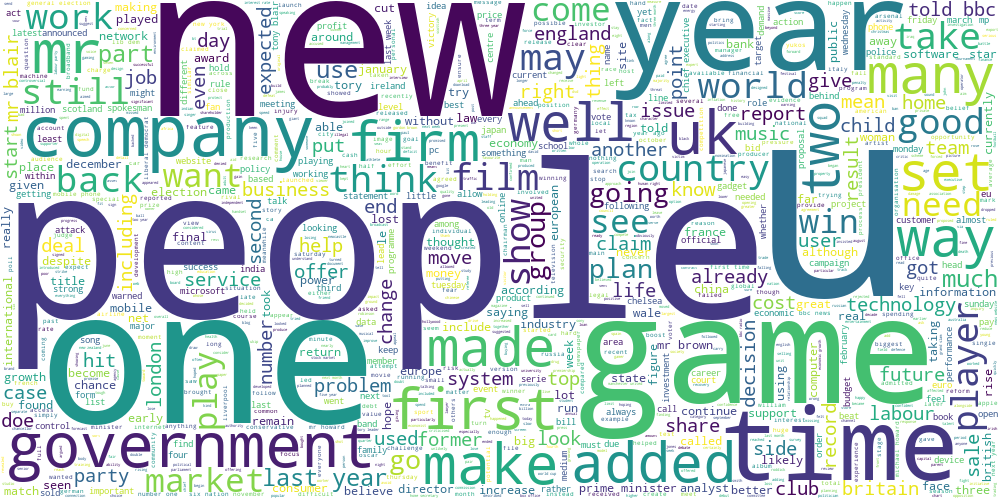

In [134]:
draw_wordcloud(data.text)

**Задание 2.1 (1 балл).** Обучите алгоритм K-Means на tf-idf представлениях текстов. При обучении tf-idf векторайзера рекомендуется отбрасывать редко встречающиеся слова, а также воздержитесь от использования N-грамм. Возьмите не очень большое число кластеров, чтобы было удобно интерпретировать получившиеся темы (например, `n_clusters` = 8). Постройте облака тегов для текстов из разных кластеров. Получились ли темы интерпретируемыми? Попробуйте озаглавить каждую тему.



In [135]:
# YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features = 1000, min_df = 0.05)
embeddings = tfidf.fit_transform(data.text)

km = KMeans(8)
labels = km.fit_predict(embeddings)

data['label'] = labels

In [136]:
import matplotlib.pyplot as plt

def visualize_clusters(data, clusters): 
    fig = plt.figure(figsize=(16, 4 * (clusters + 1) // 4))
    for i in range(data['label'].unique().max()+1):
        ax = fig.add_subplot((clusters + 1)//4, 4, i+1)
        ax.grid(False)
        ax.axis('off')

        wordcloud = WordCloud(background_color="white", max_words=2000, width=900, height=900, collocations=False)
        joint_texts = ' '.join(list(data[data['label']==i].text))
        wc = wordcloud.generate(joint_texts)

        ax.imshow(wc, interpolation='bilinear')
        ax.set_title("Cluster {}".format(i+1))

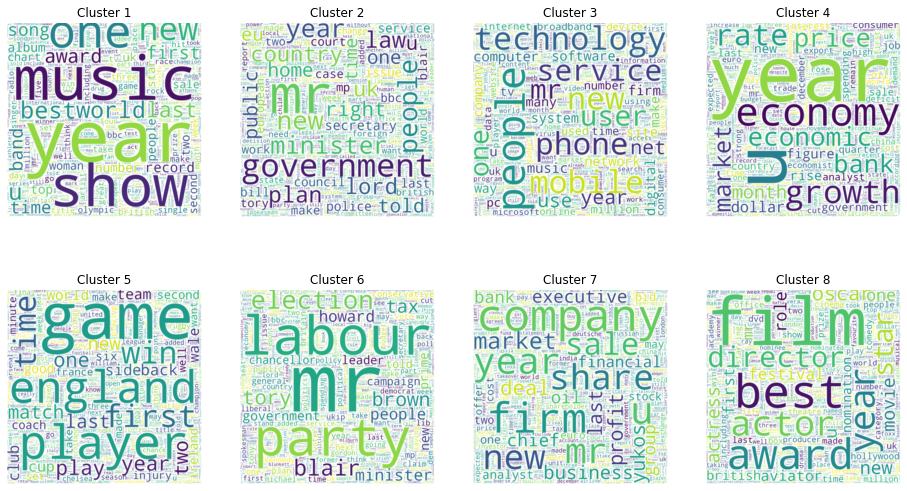

In [137]:
visualize_clusters(data, 8)

**Ответ:**

1. Музыка
2. Политика (события?)
3. Технологии
4. Экономика (Макроэкономика)
5. Спорт
6. Политика (выборы)
7. Экономика (Фондовый рынок)
8. Фильмы

In [138]:
from sklearn.manifold import TSNE

embeddings_tsne = TSNE(n_components=2).fit_transform(embeddings)

labels_list = []
labels_list.append(('K-Means', labels))

**Задание 2.2 (0.5 балла).** Попробуем другой способ выделить ключевые слова для каждой темы. Помимо непосредственного разбиения объектов алгоритм K-Means получает центр каждого кластера. Попробуйте взять центры кластеров и посмотреть на слова, для которых значения соответствующих им признаков максимальны. Согласуются ли полученные слова с облаками тегов из прошлого задания?

**Ответ:** Да)

In [139]:
# YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿

# создаем массив из слов, в котором индекс слов сопоставлен с индексом в TF-IDF
idx_to_word = np.array([word for word, _ in sorted(tfidf.vocabulary_.items(), key=lambda x: x[1])])

for i in range(8):
    # для каждого кластера выводим 7 слов с наибольшим значением tfidf параметра в векторе центроиде кластера
    print('Cluster {}:'.format(i), idx_to_word[np.argsort(km.cluster_centers_[i])[-7:][::-1]])

Cluster 0: ['show' 'music' 'year' 'award' 'world' 'best' 'record']
Cluster 1: ['mr' 'government' 'would' 'minister' 'law' 'plan' 'country']
Cluster 2: ['technology' 'people' 'mobile' 'user' 'phone' 'software' 'computer']
Cluster 3: ['economy' 'growth' 'rate' 'price' 'economic' 'bank' 'dollar']
Cluster 4: ['game' 'player' 'england' 'match' 'win' 'club' 'cup']
Cluster 5: ['mr' 'labour' 'election' 'party' 'blair' 'tory' 'brown']
Cluster 6: ['company' 'firm' 'share' 'sale' 'profit' 'deal' 'market']
Cluster 7: ['film' 'award' 'best' 'actor' 'star' 'director' 'movie']


**Задание 2.3 (1.5 балла).** В первой части мы сравнили три разных алгоритма кластеризации на географических данных. Проделаем то же самое для текстовых данных (в качестве признакого описания снова используем tf-idf). Получите три разбиения на кластеры с помощью алгоритмов K-Means, DBSCAN и спектральной кластеризации (на этот раз воспользуйтесь реализацией из `sklearn`). Для K-Means и спектральной кластеризации возьмите одинаковое небольшое число кластеров, подберите параметр `eps` метода DBSCAN так, чтобы получить приблизительно такое же число кластеров.

Далее, обучите двухмерные t-SNE представления над tf-idf признаками текстов. Визуализируйте эти представления для каждого алгоритма, раскрасив каждый кластер своим цветом. Лучше всего расположить визуализации на одном графике на трех разных сабплотах. Не забудьте, что DBSCAN помечает некоторые точки как шумовые (можно раскрасить их в отдельный цвет).

In [140]:
# YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿
from sklearn.cluster import DBSCAN, SpectralClustering

dbs = DBSCAN(eps=1.05)
labels = dbs.fit_predict(embeddings)

In [141]:
np.unique(labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7], dtype=int64)

Убеждаемся, что кластеров 8.

In [142]:
labels_list.append(('DBSCAN', labels))

spec = SpectralClustering(8)
labels = spec.fit_predict(embeddings)

labels_list.append(('Spectral', labels))

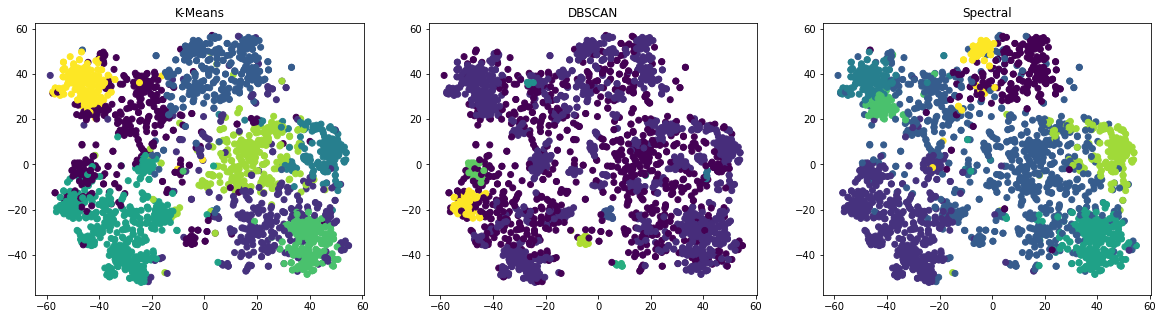

In [143]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for i in range(3):
    axes[i].scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=labels_list[i][1])
    axes[i].set_title(labels_list[i][0])

In [145]:
# распределение по кластерам DBSCAN
pd.Series(labels_list[1][1]).value_counts().sort_index()

-1     823
 0    1271
 1      15
 2       5
 3       5
 4       9
 5      27
 6      17
 7      53
dtype: int64

Прокомментируйте получившиеся результаты. Какой баланс кластеров получился у разных методов? Соотносятся ли визуализации для текстов с визуализациями для географических данных?

**Ответ:** Алгоритм спектральной кластеризации и K-Means выдают похожие результаты по балансу кластеров. Даже сами кластеры получились довольно похожими. DBSCAN делает что-то странное - почти все объекты попадают в один большой кластер, другая масса объектов помечаются как шумовые, остальные кластеры совсем малочисленные. В задании с остановками у DBSCAN тоже такое встречалось, когда пробовал разные значения для параметра `eps`.

**Задание 2.4 (1.5 балла).** Обучите модель латентного размещения Дирихле. Не забудьте, что она работает с мешком слов, а не с tf-idf признаками. Придумайте, как превратить распределение тем для текста в номер его кластера. Возьмите параметр `n_components` в 2-3 раза больше, чем число кластеров для K-Means. Получились ли темы более узкими от такого нововведения? Постройте облака тегов для нескольких наиболее удачных тем.


In [14]:
from sklearn.feature_extraction.text import CountVectorizer

bow = CountVectorizer(min_df=0.05)
bow_embs = bow.fit_transform(data.text)

In [16]:
# YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=24)
lda.fit(bow_embs)

data['label'] = lda.transform(bow_embs).argmax(axis=1)

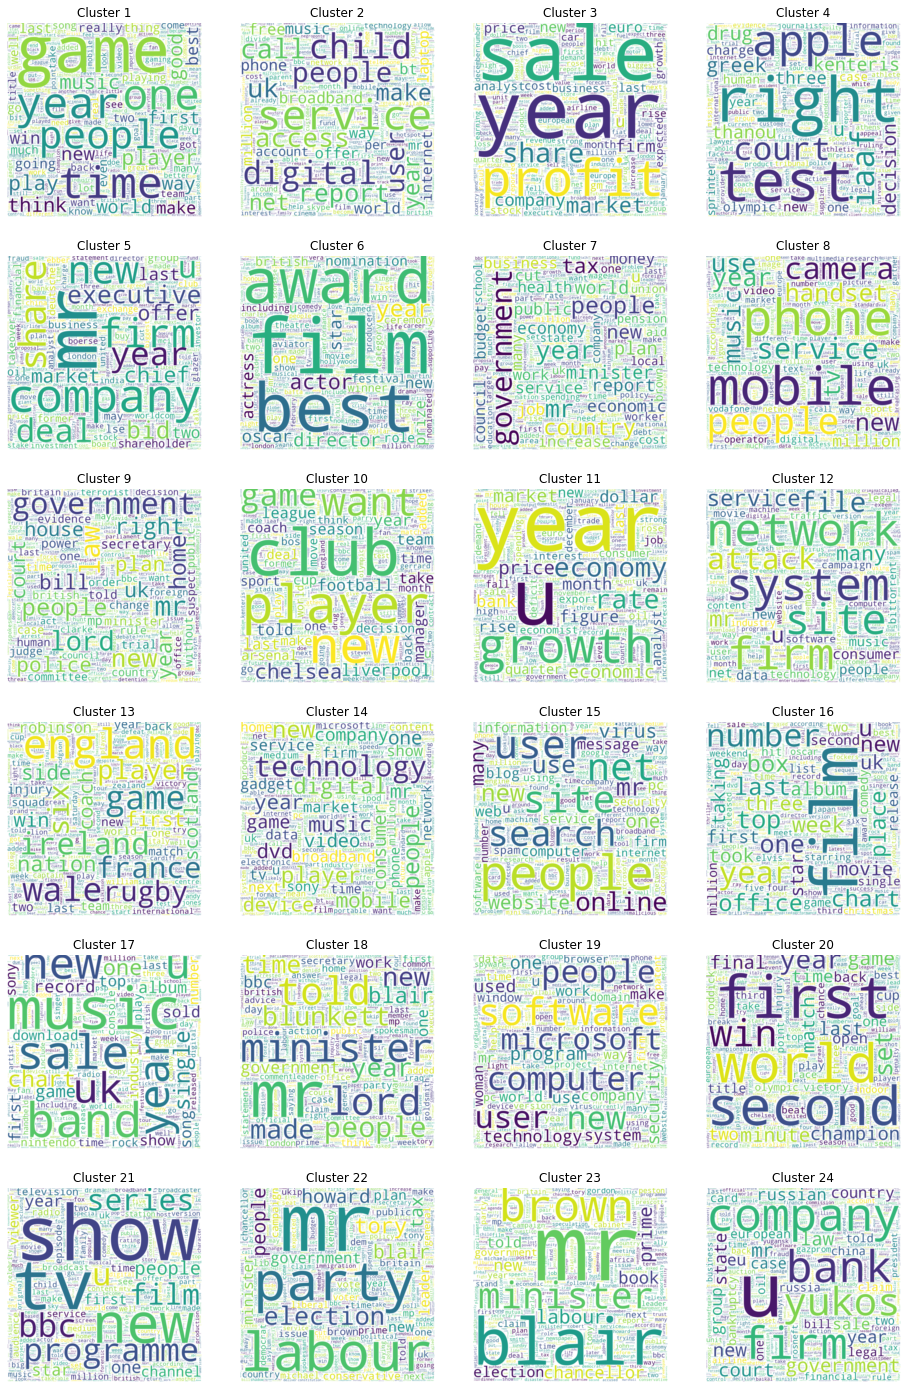

In [150]:
visualize_clusters(data, lda.n_components)

Да, темы стали более узкими. Например:

4) Допинг;
8) Мобильные телефоны; 
10) Футбол;
24) Юкос

## Часть 3. Transfer learning для задачи классификации текстов

**Задание 3.1 (0.5 балла).** Вспомним, что у нас есть разметка для тематик статей. Попробуем обучить классификатор поверх unsupervised-представлений для текстов. Рассмотрите три модели:

* Логистическая регрессия на tf-idf признаках
* K-Means на tf-idf признаках + логистическая регрессия на расстояниях до центров кластеров
* Латентное размещение Дирихле + логистическая регрессия на вероятностях тем

Разделите выборку на обучающую и тестовую, замерьте accuracy на обоих выборках для всех трех моделей. Параметры всех моделей возьмите равными значениям по умолчанию.

In [312]:
# YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

X_train, X_test, y_train, y_test = train_test_split(data.text, data.category, test_size=0.25)

tfidf = TfidfVectorizer(min_df=0.05)
X_train_emb = tfidf.fit_transform(X_train)
X_test_emb = tfidf.transform(X_test)

logreg = LogisticRegression()
logreg.fit(X_train_emb, y_train)

print('Accuracy на обучающей выборке:', np.mean(logreg.predict(X_train_emb) == y_train))
print('Accuracy на тестовой выборке:', np.mean(logreg.predict(X_test_emb) == y_test))

Accuracy на обучающей выборке: 0.9862110311750599
Accuracy на тестовой выборке: 0.9515260323159784


In [19]:
from sklearn.cluster import KMeans

km = KMeans()
X_train_center_dist =km.fit_transform(X_train_emb)
X_test_center_dist = km.transform(X_test_emb)
    
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_center_dist, y_train)

print('Accuracy на обучающей выборке:', np.mean(logreg.predict(X_train_center_dist) == y_train))
print('Accuracy на тестовой выборке:', np.mean(logreg.predict(X_test_center_dist) == y_test))

Accuracy на обучающей выборке: 0.895083932853717
Accuracy на тестовой выборке: 0.8833034111310593


In [18]:
from sklearn.decomposition import LatentDirichletAllocation

bow = CountVectorizer(min_df=0.05)
bow_train = bow.fit_transform(X_train)
bow_test = bow.transform(X_test)

lda = LatentDirichletAllocation()
lda_features_train = lda.fit_transform(bow_train)
lda_features_test = lda.transform(bow_test)

logreg = LogisticRegression()
logreg.fit(lda_features_train, y_train)

print('Accuracy на обучающей выборке:', np.mean(logreg.predict(lda_features_train) == y_train))
print('Accuracy на тестовой выборке:', np.mean(logreg.predict(lda_features_test) == y_test))

Accuracy на обучающей выборке: 0.9412470023980816
Accuracy на тестовой выборке: 0.9353680430879713


У какой модели получилось лучшее качество? С чем это связано?

**Ответ:** Лучшей моделью оказалась первая: tf-idf + логистическая регрессия. Так вышло, потому что у этой модели больше всего признаков, информация не терялась при переходе из признакового промастранства tf-idf в пространство меньшей размерности, где размерность равна числу кластеров или компонент.

**Задание 3.2 (1.5 балла).** Теперь просимулируем ситуацию слабой разметки, которая часто встречается в реальных данных. Разделим обучающую выборку в пропорции 5:65:30. Будем называть части, соответственно, размеченный трейн, неразмеченный трейн и валидация.

Все unsupervised-алгоритмы (векторайзеры и алгоритмы кластеризации) запускайте на всем трейне целиком (размеченном и неразмеченном, суммарно 70%), а итоговый классификатор обучайте только на размеченном трейне (5%). Подберите гиперпараметры моделей по качеству на валидации (30%), а затем оцените качество на тестовой выборке (которая осталась от прошлого задания). Не скромничайте при подборе числа кластеров, сейчас нас интересует не интерпретируемое разбиение выборки, а итоговое качество классификации. 

In [23]:
# YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train_70, X_valid, y_train_70, y_valid = train_test_split(X_train, y_train, test_size=0.3)
X_train_5, X_train_65, y_train_5, _ = train_test_split(X_train_70, y_train_70, train_size=5/65)

tfidf = TfidfVectorizer(min_df=0.05)
embeddings_train_70 = tfidf.fit_transform(X_train_70)
embeddings_train_5 = tfidf.transform(X_train_5)
embeddings_valid = tfidf.transform(X_valid)

accuracy_list = []
c_list = [0.01, 0.1, 0.5, 1, 10, 100, 1000, 10000]

# подбираем оптимальный С по валидации
for c in c_list:
    logreg = LogisticRegression(C=c)
    logreg.fit(embeddings_train_5, y_train_5)
    
    y_valid_pred = logreg.predict(embeddings_valid)
    accuracy_list.append(np.mean(y_valid_pred==y_valid))
    
# сохраняем лучшее значенеие
C_best = c_list[np.argmax(accuracy_list)]
print('Далее будет использоваться значение параметра C={}'.format(C_best))

Далее будет использоваться значение параметра C=100


In [24]:
embeddings_test = tfidf.transform(X_test)

logreg = LogisticRegression(C=C_best)
logreg.fit(embeddings_train_5, y_train_5)

y_test_pred = logreg.predict(embeddings_test)

print('Логистическая регрессия на tf-idf признаках\nAccuracy на тестовой выборке:', np.mean(y_test_pred==y_test))

Логистическая регрессия на tf-idf признаках
Accuracy на тестовой выборке: 0.9030520646319569


In [25]:
from tqdm.notebook import tqdm

accuracy_list = []
n_clusters_list = range(5, 106, 5)

for n in tqdm(n_clusters_list):
    km = KMeans(n_clusters=n)
    km.fit(embeddings_train_70)
        
    km_features_train = km.transform(embeddings_train_5)
    km_features_valid = km.transform(embeddings_valid)
    
    logreg = LogisticRegression(C = C_best, max_iter = 1500)
    logreg.fit(km_features_train, y_train_5)
    
    y_valid_pred = logreg.predict(km_features_valid)
    accuracy_list.append(np.mean(y_valid_pred==y_valid))

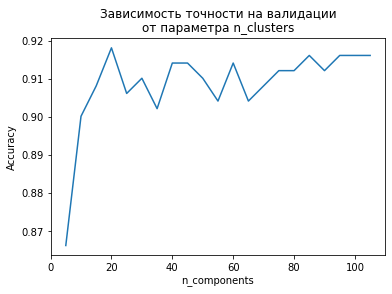

In [26]:
import matplotlib.pyplot as plt

plt.plot(n_clusters_list, accuracy_list)
plt.xlabel('n_components')
plt.ylabel('Accuracy')
plt.title('Зависимость точности на валидации\nот параметра n_clusters');

Качество выходит на плато при увеличении количества кластеров, я решил выбрать значение `n_clusters=20`.

In [27]:
embeddings_test = tfidf.transform(X_test)
km = KMeans(n_clusters=20)
km.fit(embeddings_train_70)

km_features_train = km.transform(embeddings_train_5)
km_features_test = km.transform(embeddings_test)

logreg = LogisticRegression(C = C_best, max_iter=1000)
logreg.fit(km_features_train, y_train_5)

y_test_pred = logreg.predict(km_features_test)


print('K-Means на tf-idf признаках + логистическая регрессия на расстояниях до центров кластеров\nAccuracy на тестовой выборке:', np.mean(y_test_pred==y_test))

K-Means на tf-idf признаках + логистическая регрессия на расстояниях до центров кластеров
Accuracy на тестовой выборке: 0.895870736086176


In [35]:
from tqdm.notebook import tqdm

bow = CountVectorizer(min_df=0.05)
embeddings_train_70 = bow.fit_transform(X_train_70)
embeddings_train_5 = bow.transform(X_train_5)
embeddings_valid = bow.transform(X_valid)

accuracy_list = []
n_components_list = range(5, 106, 5)

for n in tqdm(n_components_list):
    lda = LatentDirichletAllocation(n_components=n)
    lda.fit(embeddings_train_70)
    
    lda_features_train = lda.transform(embeddings_train_5)
    lda_features_valid = lda.transform(embeddings_valid)
    
    logreg = LogisticRegression(C=C_best, max_iter=1000)
    logreg.fit(lda_features_train, y_train_5)
    
    y_valid_pred = logreg.predict(lda_features_valid)
    accuracy_list.append(np.mean(y_valid_pred==y_valid))

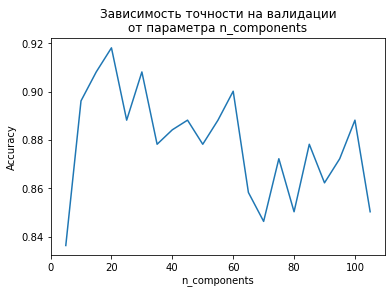

In [36]:
plt.plot(n_components_list, accuracy_list)
plt.xlabel('n_components')
plt.ylabel('Accuracy')
plt.title('Зависимость точности на валидации\nот параметра n_components');

Тут сложно что-то интерпретировать, я выбрал параметр, при котором качество на валидации максимальное.

In [37]:
embeddings_test = bow.transform(X_test)
lda = LatentDirichletAllocation(n_components=n_components_list[np.argmax(accuracy_list)])
lda.fit(embeddings_train_70)

lda_features_train = lda.transform(embeddings_train_5)
lda_features_test = lda.transform(embeddings_test)

logreg = LogisticRegression(C=C_best)
logreg.fit(lda_features_train, y_train_5)

y_test_pred = logreg.predict(lda_features_test)

print('Латентное размещение Дирихле + логистическая регрессия на вероятностях тем\nAccuracy на тестовой выборке:', np.mean(y_test_pred==y_test))

Латентное размещение Дирихле + логистическая регрессия на вероятностях тем
Accuracy на тестовой выборке: 0.9048473967684022


Как изменились результаты по сравнению с обучением на полной разметке? Сделайте выводы.

**Ответ:** Точность всех моделей снизиласть, но недраматично. Причем качество моделей, использовавших кластеризацию, просело слабее. Вывод: даже на данных с неполной разметкой можно обучить качественную модель.

## Бонус

**Задание 4 (1 балл)**. Разберитесь с semi-supervised методами, которые реализованы в `sklearn` и примените их к заданию 3.2. Получилось ли добиться лучшего качества? Сделайте выводы.

In [124]:
# YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿
from sklearn.semi_supervised import SelfTrainingClassifier

y_self_train = y_train_70.copy()  

# убираем метки на той части выборки, которая как бы неразмеченная
y_self_train[X_train_70.index.isin(X_train_65.index)] = -1

tfidf = TfidfVectorizer(min_df=0.05)
embeddings_train_70 = tfidf.fit_transform(X_train_70)
embeddings_valid = tfidf.transform(X_valid)
embeddings_test = tfidf.transform(X_test)

logreg = LogisticRegression()

accuracy_list = []
threshold_list = np.arange(0.5, 0.96, 0.05)

# подберем оптимальный порог
for t in threshold_list:
    clf = SelfTrainingClassifier(logreg, threshold=t)
    clf.fit(embeddings_train_70, y_self_train)
    
    y_valid_pred = clf.predict(embeddings_valid)
    accuracy_list.append(np.mean(y_valid_pred==y_valid))
    
    
clf = SelfTrainingClassifier(logreg, threshold=threshold_list[np.argmax(accuracy_list)])
clf.fit(embeddings_train_70, y_self_train)
print('Self-training accuracy:', np.mean(clf.predict(embeddings_test) == y_test))

Self-training accuracy: 0.8330341113105925


In [131]:
from sklearn.semi_supervised import LabelPropagation
from IPython.display import clear_output

# этот классификатор более капризный, придется закодировать все метки
labels = y_train_70.unique()
labels_dict = {labels[i] : i for i in range(len(labels))}
y_label_encoded = y_train_70.map(labels_dict)

y_label_encoded[X_train_70.index.isin(X_train_65.index)] = -1

accuracy_list = []
gamma_list = range(1, 31)

for g in gamma_list:
    lp = LabelPropagation(gamma=g)
    lp.fit(embeddings_train_70.toarray(), y_label_encoded)
    clear_output()
    y_valid_pred = lp.predict(embeddings_valid)
    accuracy_list.append(np.mean(y_valid_pred==y_valid.map(labels_dict)))
    
lp = LabelPropagation(gamma=gamma_list[np.argmax(accuracy_list)])
lp.fit(embeddings_train_70.toarray(), y_label_encoded)
clear_output()
print('Label propagation accuracy:', np.mean(lp.predict(embeddings_test) == y_test.map(labels_dict)))

Label propagation accuracy: 0.8653500897666068


In [136]:
from sklearn.semi_supervised import LabelSpreading

accuracy_list = []
gamma_list = range(1, 31)

for g in gamma_list:
    ls = LabelSpreading(gamma=g)
    ls.fit(embeddings_train_70.toarray(), y_label_encoded)
    
    y_valid_pred = ls.predict(embeddings_valid)
    accuracy_list.append(np.mean(y_valid_pred==y_valid.map(labels_dict)))

ls = LabelSpreading(gamma=gamma_list[np.argmax(accuracy_list)])
ls.fit(embeddings_train_70.toarray(), y_label_encoded)

print('Label spreading accuracy:', np.mean(ls.predict(embeddings_test) == y_test.map(labels_dict)))

Label spreading accuracy: 0.874326750448833


Сначала я зпустил все три модели с дефолтными настройками и получил точности 0.83, 0.84, 0.84 соответсовенно. Потом я решил все же немного настроить гиперпараметры по валидации: для `SelfTrainingClassifier` подбирал параметр `threshold`, для `LabelSpreading` и `LabelPropagation` - параметр `gamma`. Подбор гиперпараметров смог немного улучшить качество двух последних моделей, но все равно качество моделей из предыдущего задания выше. Не буду утверждать, что алгоритмы кластеризации позволяют лучше решать задачи на неполных данных, чем алгоритмы semi-supervised learning. Думаю, что это зависит от данных и конкретно на этих данных первый подход оказался лучше.

**Задание 5 (1 балл)**. На занятиях мы обсуждали, что метрика [BCubed](https://www.researchgate.net/profile/Julio-Gonzalo-2/publication/225548032_Amigo_E_Gonzalo_J_Artiles_J_et_alA_comparison_of_extrinsic_clustering_evaluation_metrics_based_on_formal_constraints_Inform_Retriev_12461-486/links/0c96052138dbb99740000000/Amigo-E-Gonzalo-J-Artiles-J-et-alA-comparison-of-extrinsic-clustering-evaluation-metrics-based-on-formal-constraints-Inform-Retriev-12461-486.pdf) хорошо подходит для сравнения алгоритмов кластеризации, если нам известно настоящее разделение на кластеры (gold standard). Реализуйте подсчет метрики BCubed и сравните несколько алгоритмов кластеризации на текстовых данных из основного задания. В качестве gold standard используйте разметку category.

In [308]:
# YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿

def recall_bcubed(labels, gold_standard):
    data = pd.DataFrame({'category':gold_standard, 'label':labels})
    correctness = 0
    categories = data['category'].unique()
    for category in categories:
        correctness += np.max(data[data['category']==category]['label'].value_counts())
    
    return correctness/len(data)

def precision_bcubed(labels, gold_standard):
    data = pd.DataFrame({'category':gold_standard, 'label':labels})
    correctness = 0
    labels_unique = data['label'].unique()
    for label in labels_unique:
        correctness += np.max(data[data['label']==label]['category'].value_counts())
    
    return correctness/len(data)

def bcubed(labels, gold_standard):
    p = precision_bcubed(labels, gold_standard)
    r = recall_bcubed(labels, gold_standard)
    return 2*p*r/(p+r)

Для чистоты эксперимента проведем 25 итераций и посмотрим на среднюю оценку.

In [319]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.decomposition import LatentDirichletAllocation

tfidf = TfidfVectorizer(max_features = 1000, min_df = 0.05)
embeddings = tfidf.fit_transform(data.text)

bow = CountVectorizer(min_df=0.05)
bow_embs = bow.fit_transform(data.text)

gold_standard = data.category

km_list = []
spec_list = []
lda_list = []
for i in tqdm(range(25)):
    km = KMeans(5)
    labels = km.fit_predict(embeddings)
    km_list.append(bcubed(labels, gold_standard))
    
    spec = SpectralClustering(5)
    labels = spec.fit_predict(embeddings)
    spec_list.append(bcubed(labels, gold_standard))
    
    lda = LatentDirichletAllocation(5)
    labels = lda.fit_transform(bow_embs).argmax(axis=1)
    lda_list.append(bcubed(labels, gold_standard))

In [320]:
print('BCubed K-means:', np.mean(km_list))
print('BCubed Spectral Clustering:', np.mean(spec_list))
print('BCubed LDA:', np.mean(lda_list))

BCubed K-means: 0.8204584269662922
BCubed Spectral Clustering: 0.8205303370786516
BCubed LDA: 0.8336134155653216


Я решил не останавливаться на средних, а сделать кое-что еще:

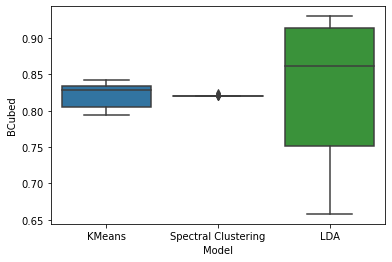

In [321]:
import seaborn as sns

df = pd.DataFrame({'BCubed':km_list+spec_list+lda_list,
                   'Model': ['KMeans']*25+['Spectral Clustering']*25+['LDA']*25})

sns.boxplot(data = df, x='Model', y='BCubed');

У спектральной кластеризации получилась самая стабильная оценка. Хотя у LDA самая высокая средняя оценка, у этого алгоритма довольно сильный разброс.

**Задание 6 (2 баллa)**. Спектральная кластеризация, по сути, является обычной кластеризацией KMeans поверх эмбеддингов объектов, которые получаются из лапласиана графа. А что, если мы попробуем построить эмбеддинги каким-нибудь другим способом? В этом задании мы предлагаем вам проявить немного фантазии. Возьмите какие-нибудь данные высокой размерности, чтобы задача обучения эмбеддингов имела смысл (например, картинки или тексты, желательно выбрать что-нибудь оригинальное). Придумайте или найдите какой-нибудь метод обучения эмбеддингов, примените его к данным и кластеризуйте полученные представления. Если чувствуете в себе достаточно силы, можете попробовать что-нибудь нейросетевое. Сравните ваш подход с базовыми алгоритмами кластеризации, которое мы рассмотрели в основном задании, не забывайте про визуализации! Ключевые слова для вдохновения: ***KernelPCA***, ***UMAP***, ***autoencoders***, ***gensim***. 

In [ ]:
# YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿

**Задание 7 (1e-100 балла)**. Опишите свои ощущения от этой домашки, поощряется сравнение с предыдущей.

In [301]:
# YOUR CODE HERE (ノಠ益ಠ)ノ彡┻━┻
# вроде бы менее муторно, чем с ЕМ, но все равно задолбался